In [ ]:
import tensorflow as tf
import os
# Connect to TPU
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to the preprocessed dataset
preprocessed_data_path = '/content/drive/MyDrive/yuksekTez/airline_dataset/preprocessed_data18-09.csv'

# Load the preprocessed data
df = pd.read_csv(preprocessed_data_path)

Mounted at /content/drive


In [ ]:
# Prepare data
X = df.drop('label', axis=1).values
y = df['label'].values

# Reshape the input data to be 3D
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
# Define the model-building function (to be used inside the strategy.scope())
def build_model():
    model = Sequential([
        GRU(64, input_shape=(X.shape[1], X.shape[2])),
        Dense(3, activation='softmax')  # 3 output neurons for 3 classes, softmax for multi-class classification
    ])
    return model

# Use the strategy scope to distribute the training
with strategy.scope():
    model = build_model()
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
with strategy.scope():
   # Define EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    # Train the model with early stopping
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=64, callbacks=[early_stopping])

Epoch 1/50
323/323 [==============================] - 35s 97ms/step - loss: 1.0581 - accuracy: 0.4459 - val_loss: 1.0309 - val_accuracy: 0.4818
Epoch 2/50
323/323 [==============================] - 28s 87ms/step - loss: 1.0155 - accuracy: 0.4875 - val_loss: 1.0067 - val_accuracy: 0.4943
Epoch 3/50
323/323 [==============================] - 28s 86ms/step - loss: 0.9949 - accuracy: 0.5067 - val_loss: 1.0107 - val_accuracy: 0.4878
Epoch 4/50
323/323 [==============================] - 28s 86ms/step - loss: 0.9797 - accuracy: 0.5236 - val_loss: 0.9620 - val_accuracy: 0.5349
Epoch 5/50
323/323 [==============================] - 28s 87ms/step - loss: 0.9659 - accuracy: 0.5379 - val_loss: 0.9607 - val_accuracy: 0.5278
Epoch 6/50
323/323 [==============================] - 28s 86ms/step - loss: 0.9552 - accuracy: 0.5409 - val_loss: 0.9587 - val_accuracy: 0.5319
Epoch 7/50
323/323 [==============================] - 28s 86ms/step - loss: 0.9386 - accuracy: 0.5525 - val_loss: 0.9073 - val_accuracy:

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy * 100:.2f}%')

# Generate predictions
y_pred = np.argmax(model.predict(X_test), axis=-1)

# Print classification report
print(classification_report(y_test, y_pred))

22/22 [==============================] - 2s 51ms/step - loss: 0.6747 - accuracy: 0.7170
Test accuracy: 71.70%
22/22 [==============================] - 2s 56ms/step
              precision    recall  f1-score   support

         0.0       0.71      0.77      0.74       242
         1.0       0.69      0.57      0.63       222
         2.0       0.74      0.80      0.77       225

    accuracy                           0.72       689
   macro avg       0.72      0.71      0.71       689
weighted avg       0.72      0.72      0.71       689



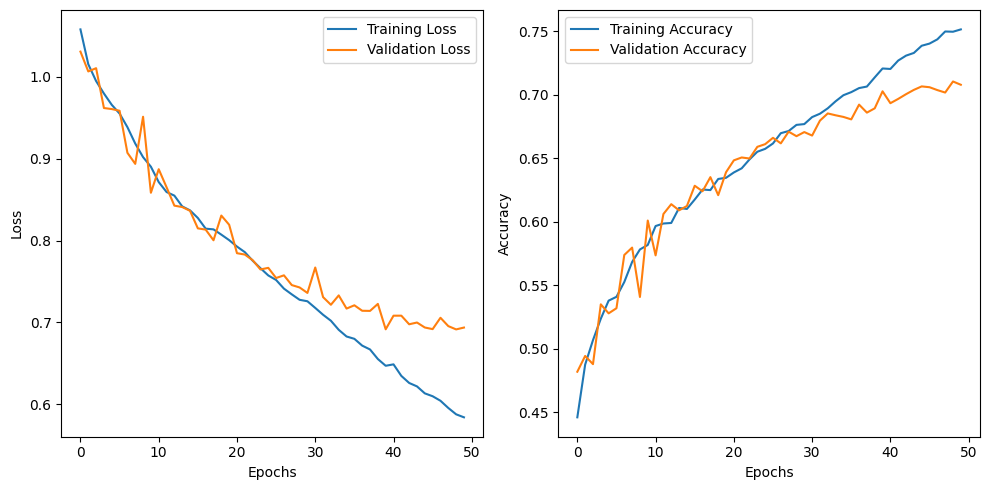

In [ ]:
import matplotlib.pyplot as plt

# Access training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
